In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data = pd.read_csv('./data/after_getform_4.csv')
data.head()

,Unnamed: 0,date,month,team,opponent,venue,time,round,day,result,...,performance off_form,performance crs_form,performance int_form,performance tklw_form,performance pkwon_form,performance pkcon_form,performance og_form,performance recov_form,aerial duels won_form,aerial duels lost_form
0,0,2024-08-25,8,1,19,1,16,2,6,3,...,4.00,20.50,7.75,11.00,0.00,0.0,0.0,48.00,11.25,7.00
1,1,2024-09-14,9,1,22,1,15,4,5,0,...,1.50,17.25,7.50,11.00,0.00,0.0,0.0,48.25,12.75,7.00
2,2,2024-09-21,9,1,16,1,15,5,5,3,...,0.75,15.75,8.25,9.75,0.00,0.0,0.0,46.75,14.50,9.00
3,3,2024-10-20,10,1,5,1,16,8,6,3,...,0.50,16.00,9.25,9.25,0.25,0.0,0.0,44.75,16.75,8.75
4,4,2024-11-02,11,1,7,1,15,10,5,3,...,2.00,16.25,7.75,10.50,0.50,0.0,0.0,39.75,13.50,11.25


In [8]:
column_not_need_form = ['team', 'opponent', 'venue', 'attendance', 'formation', 'oop formation', 'referee', 'captain', 'points',
                    'points_before_match', 'season', 'round', 'date', 'day', 'time', 'month', 'b365h', 'b365d', 'b365a', 'over2.5', 'under2.5']

In [9]:
data.drop(columns=['Unnamed: 0'], inplace=True)
important_col = ['gf', 'ga', 'result']
data.drop(columns=[col for col in data.columns if 'form' not in col and col not in column_not_need_form and col not in important_col], inplace=True)
data.head()

,date,month,team,opponent,venue,time,round,day,result,gf,...,performance off_form,performance crs_form,performance int_form,performance tklw_form,performance pkwon_form,performance pkcon_form,performance og_form,performance recov_form,aerial duels won_form,aerial duels lost_form
0,2024-08-25,8,1,19,1,16,2,6,3,2.0,...,4.00,20.50,7.75,11.00,0.00,0.0,0.0,48.00,11.25,7.00
1,2024-09-14,9,1,22,1,15,4,5,0,0.0,...,1.50,17.25,7.50,11.00,0.00,0.0,0.0,48.25,12.75,7.00
2,2024-09-21,9,1,16,1,15,5,5,3,3.0,...,0.75,15.75,8.25,9.75,0.00,0.0,0.0,46.75,14.50,9.00
3,2024-10-20,10,1,5,1,16,8,6,3,2.0,...,0.50,16.00,9.25,9.25,0.25,0.0,0.0,44.75,16.75,8.75
4,2024-11-02,11,1,7,1,15,10,5,3,2.0,...,2.00,16.25,7.75,10.50,0.50,0.0,0.0,39.75,13.50,11.25


In [10]:
data['season'] = data['season'].apply(lambda x: x.split('-')[0])
data['season'] = data['season'].astype(int)
data['season'].unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017])

In [11]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))

In [12]:
train_set = data[data['date'] < '2022-01-01']
test_set = data[data['date'] >= '2022-01-01']

In [14]:
predictors = [col for col in data.columns if col not in ['gf', 'ga', 'date', 'result', 'points']]
rf.fit(train_set[predictors], train_set[['gf', 'ga']]) 

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [15]:
preds = rf.predict(test_set[predictors])

In [16]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_set[['gf', 'ga']], preds)
mse

1.432729848628193

In [18]:
# test with a match
match = test_set.iloc[5]
print(match['gf'], match['ga'])
print(rf.predict([match[predictors]]))

4.0 1.0
[[3.84 0.86]]


c:\Users\admin\anaconda3\envs\ai_learning\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\admin\anaconda3\envs\ai_learning\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [19]:
gf_importances = rf.estimators_[0].feature_importances_  
ga_importances = rf.estimators_[1].feature_importances_  

avg_importances = np.mean([gf_importances, ga_importances], axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': predictors,
    'GF_Importance': gf_importances,
    'GA_Importance': ga_importances,
    'Avg_Importance': avg_importances
}).sort_values(by='Avg_Importance', ascending=False)

print(feature_importance_df)

                    Feature  GF_Importance  GA_Importance  Avg_Importance
2                  opponent       0.034575       0.099959        0.067267
8                   captain       0.104244       0.014374        0.059309
27                    b365d       0.037408       0.040703        0.039056
18          performance crs       0.043977       0.016715        0.030346
22        performance pkcon       0.001015       0.043338        0.022176
..                      ...            ...            ...             ...
137   performance crdr_form       0.001032       0.000573        0.000803
147     performance og_form       0.000664       0.000808        0.000736
14        performance 2crdy       0.000139       0.001062        0.000600
98       gca types def_form       0.000485       0.000715        0.000600
138  performance 2crdy_form       0.000653       0.000485        0.000569

[151 rows x 4 columns]


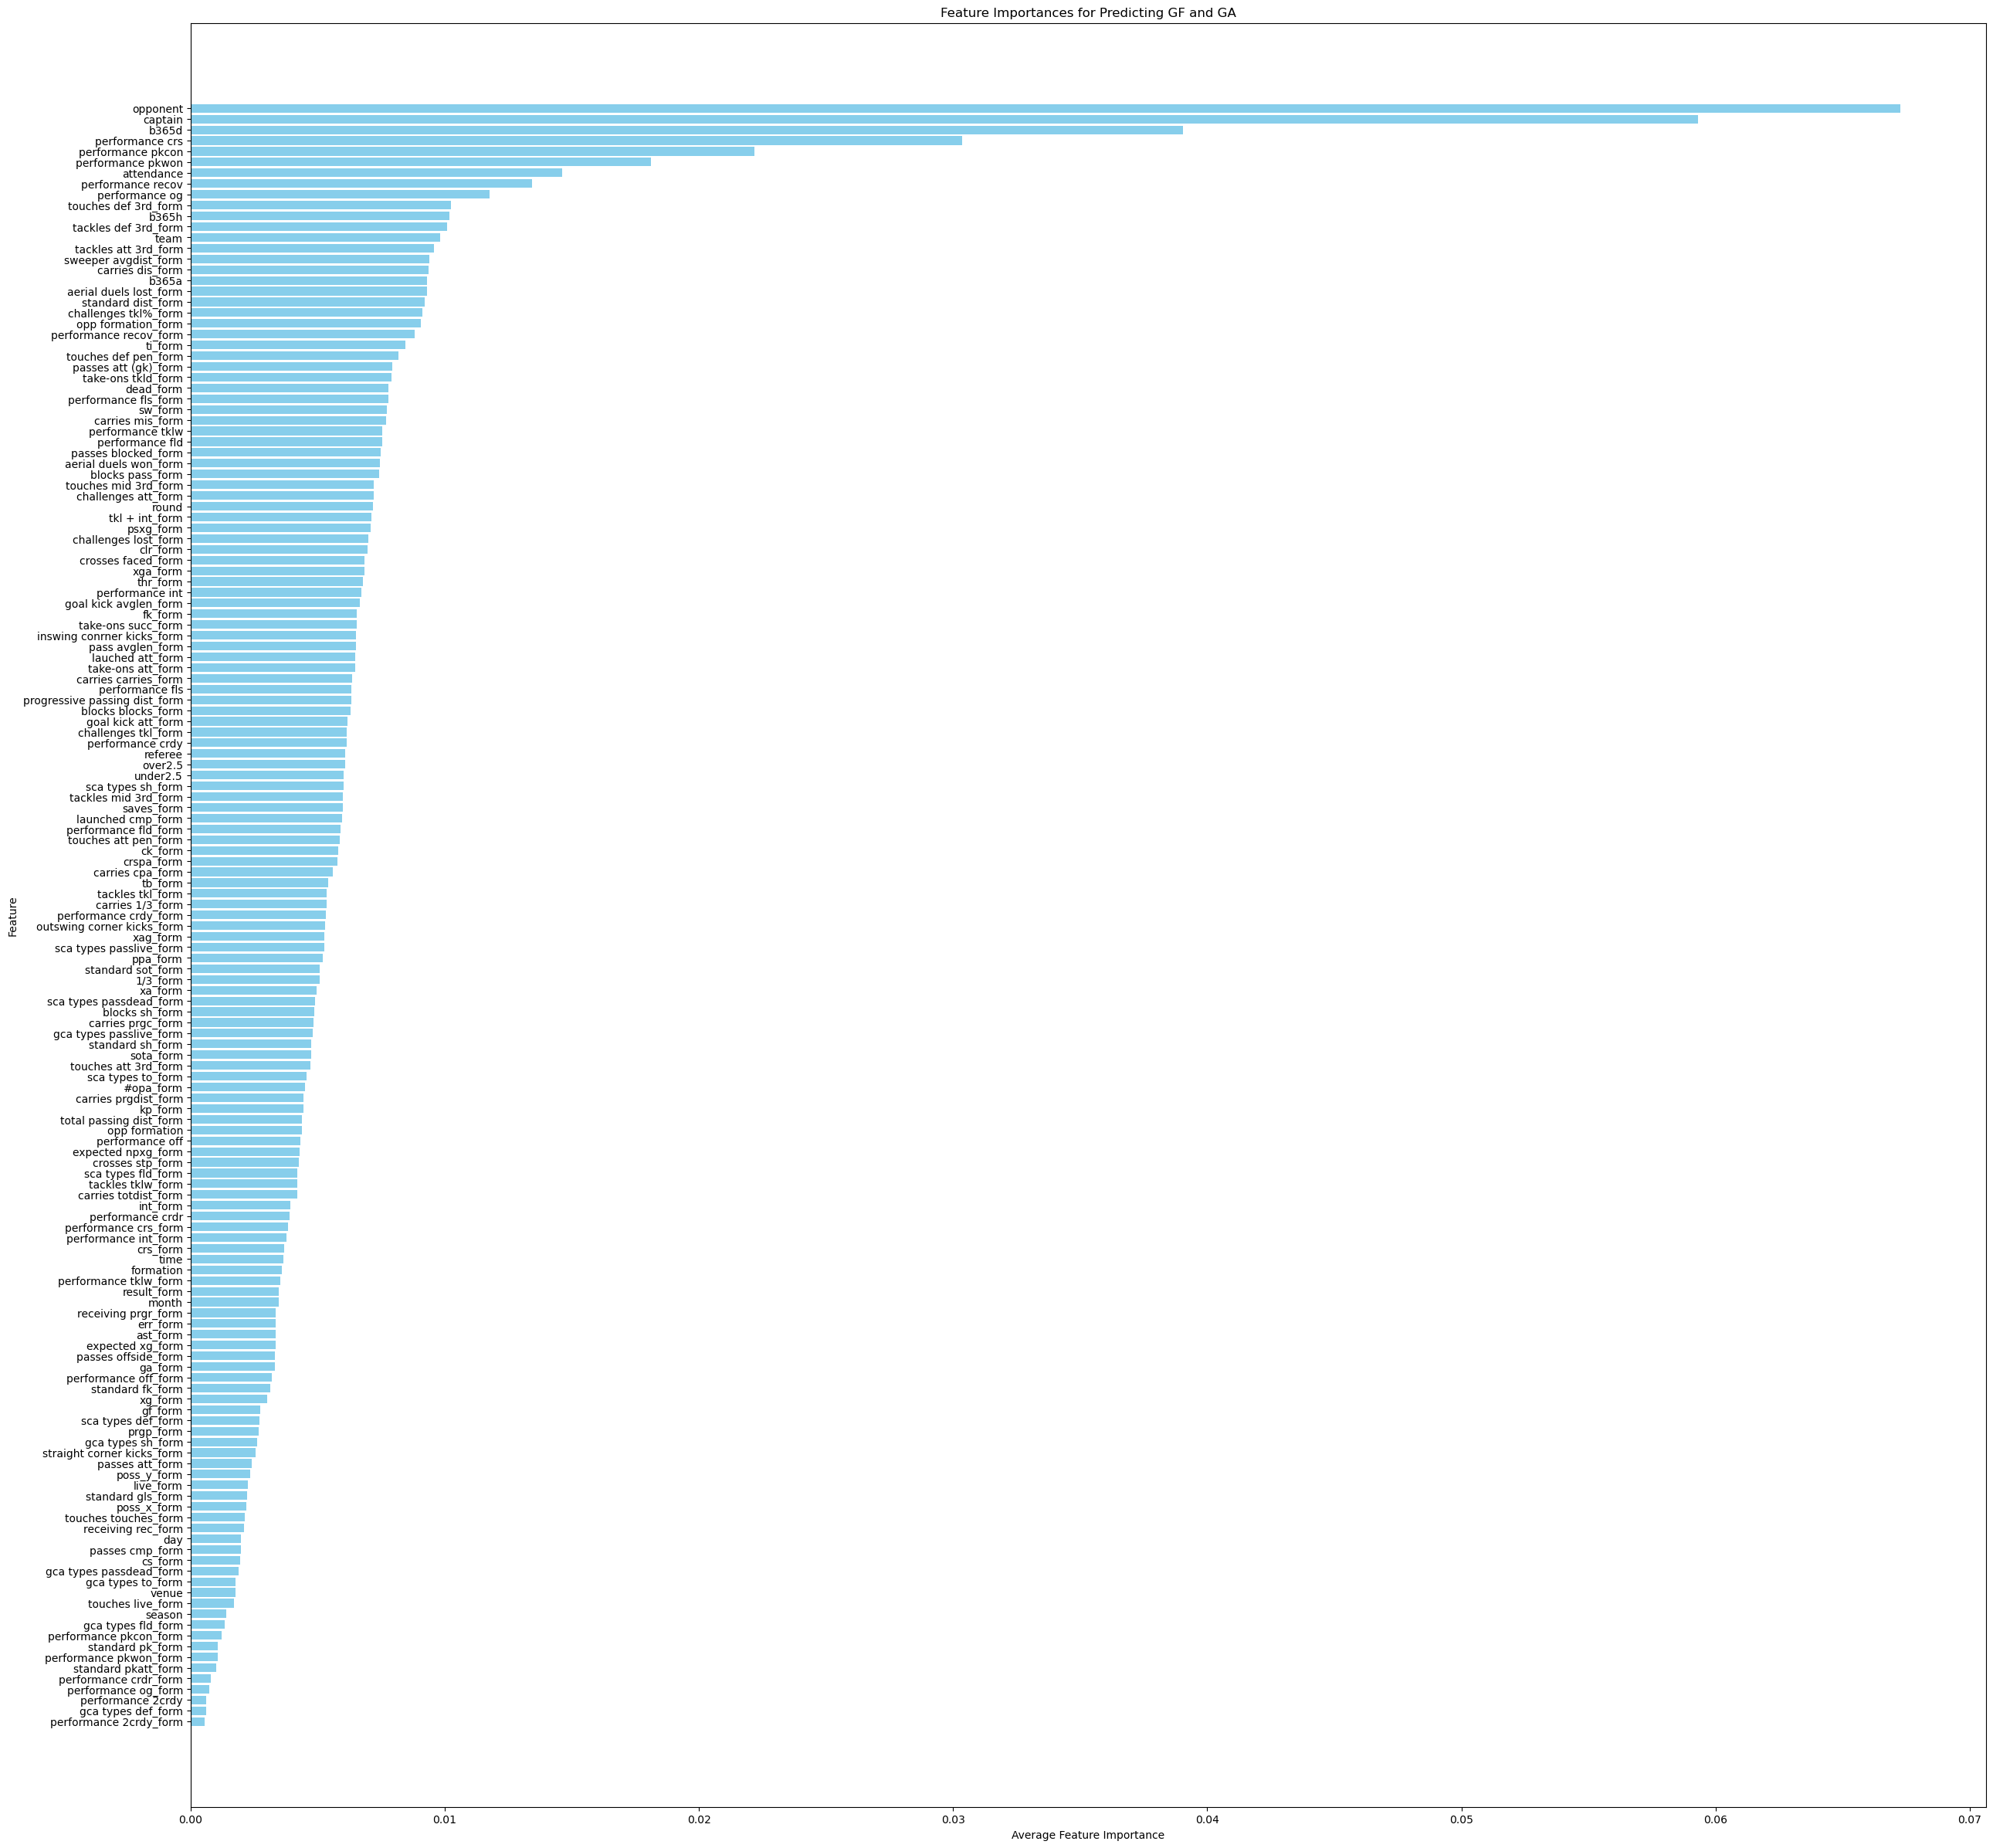

In [20]:
plt.figure(figsize=(30, 30))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Avg_Importance'], color='skyblue')
plt.xlabel('Average Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Predicting GF and GA')
plt.gca().invert_yaxis()
plt.show()